In [1]:
# 1) เตรียมไลบรารี
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import json
import plotly.graph_objects as go
import plotly.express as px
import requests


In [2]:
data = pd.read_csv('/kaggle/input/bankok-hotel/bankok_hotel.csv')
keep_data = ["name","host_id","neighbourhood","latitude","longitude","room_type","price","reviews_per_month"]
data = data[keep_data]

In [3]:
# 4) ตรวจสอบตัวอย่างข้อมูล
print(data.head(10))

                                           name  host_id neighbourhood  \
0               Nice room with superb city view   120437   Ratchathewi   
1                Easy going landlord,easy place   120541       Bang Na   
2             modern-style apartment in Bangkok   123784     Bang Kapi   
3                    Beautiful waterfront house   214456    Don Mueang   
4               Condo with Chaopraya River View   222005    Rat Burana   
5                 Sathorn Terrace Apartment(61)   263049      Bang Rak   
6  Comfy bedroom near River pier & BTS  Taksin.   263049        Sathon   
7            Luxury@swimpool/FreeWiFi/nearJJMkt   302658    Phaya Thai   
8           Central Bangkok 3 Bedroom Apartment   545890   Khlong Toei   
9            River View - Ivy Condo (1 Bedroom)   578110    Rat Burana   

   latitude  longitude        room_type   price  reviews_per_month  
0  13.75983  100.54134  Entire home/apt  1665.0               0.41  
1  13.66818  100.61674     Private room     NaN

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


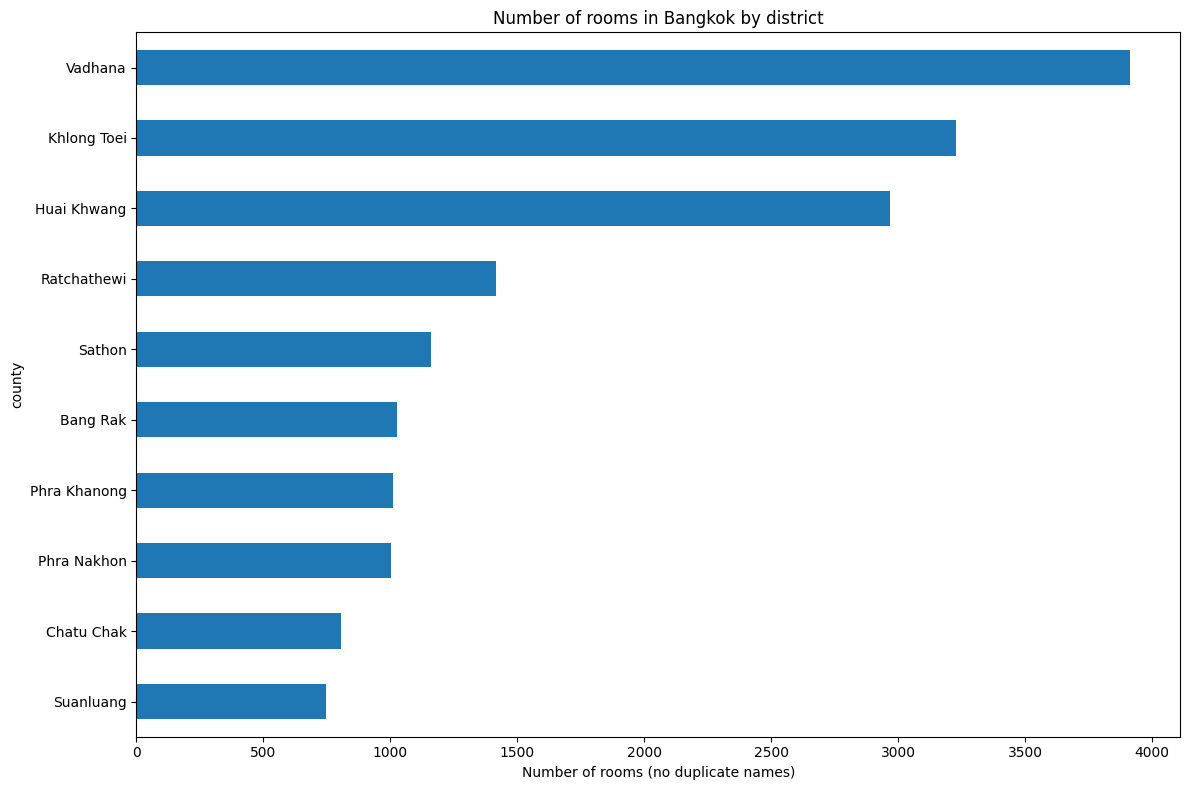

In [4]:
# 5) วิเคราะห์จำนวนห้องพักแยกตามเขต (neighbourhood)
rooms_per_district = (data
                      .groupby("neighbourhood")["name"]
                      .nunique()
                      .sort_values(ascending=False))

plt.figure(figsize=(12, 8))
rooms_per_district.head(10).plot(kind="barh")
plt.xlabel("Number of rooms (no duplicate names)")
plt.ylabel("county")
plt.title("Number of rooms in Bangkok by district")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

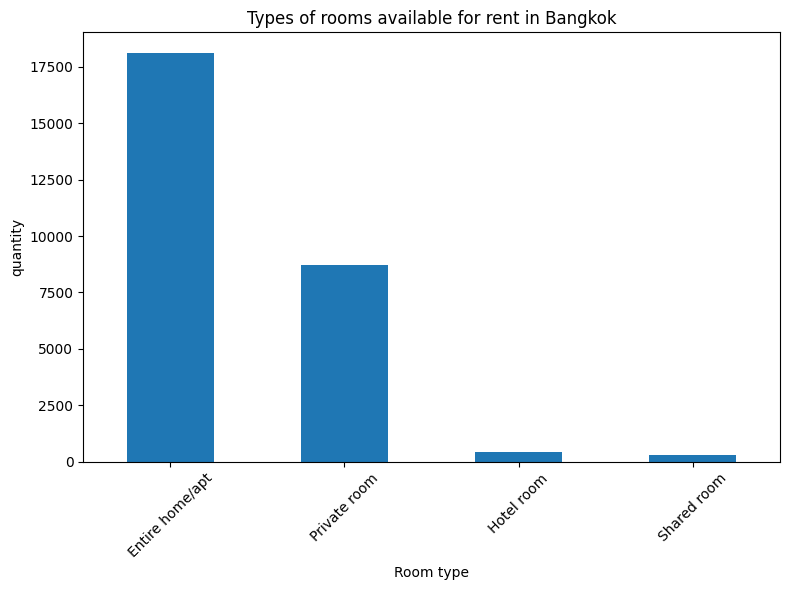

In [5]:
#วิเคราะห์ประเภทห้องพัก
rooms_per_type = data["room_type"].value_counts()

plt.figure(figsize=(8, 6))
rooms_per_type.plot(kind="bar")
plt.xlabel("Room type")
plt.ylabel("quantity")
plt.title("Types of rooms available for rent in Bangkok")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

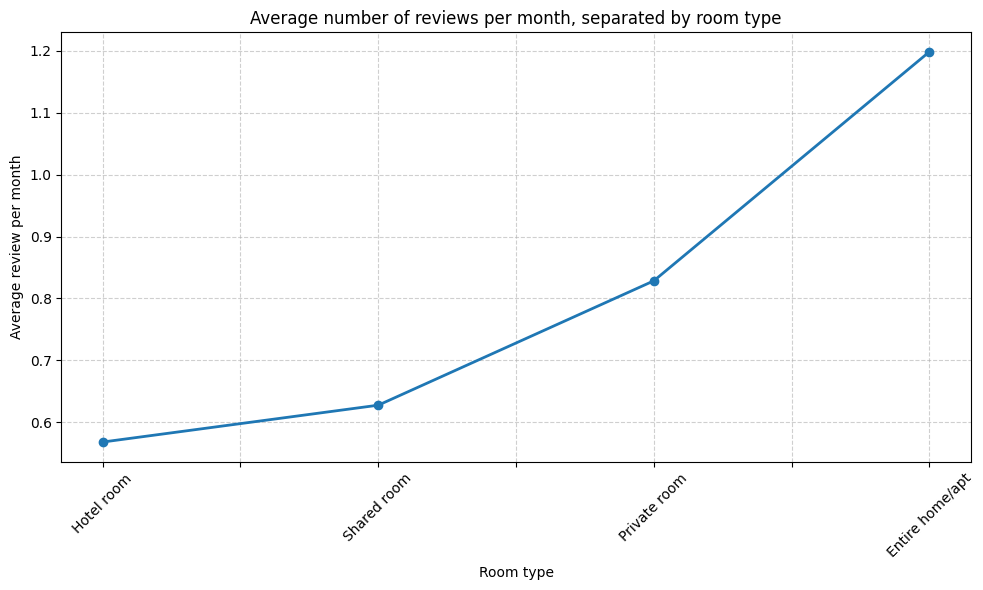

In [6]:
#กราฟเส้น: ค่าเฉลี่ยรีวิวต่อเดือน แยกตามประเภทห้องพัก
reviews_line = (data.groupby("room_type")["reviews_per_month"]
                  .mean()
                  .sort_values())

plt.figure(figsize=(10, 6))
reviews_line.plot(marker="o", linestyle="-", linewidth=2)
plt.xlabel("Room type")
plt.ylabel("Average review per month")
plt.title("Average number of reviews per month, separated by room type")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [7]:
#สร้างแผนที่แสดงตำแหน่งโรงแรม
fig = px.scatter_mapbox(
    data.dropna(subset=['latitude','longitude']),
    lat="latitude",
    lon="longitude",
    hover_name="name",
    hover_data={"neighbourhood":True, "room_type":True, "price":True},
    color="neighbourhood",
    zoom=10,
    height=700
)
fig.update_traces(marker=dict(size=5))
fig.update_layout(
    mapbox_style="open-street-map",
    title="แผนที่โรงแรม/ที่พักในกรุงเทพมหานคร (แบ่งสีตามเขต)"
)
fig.show()

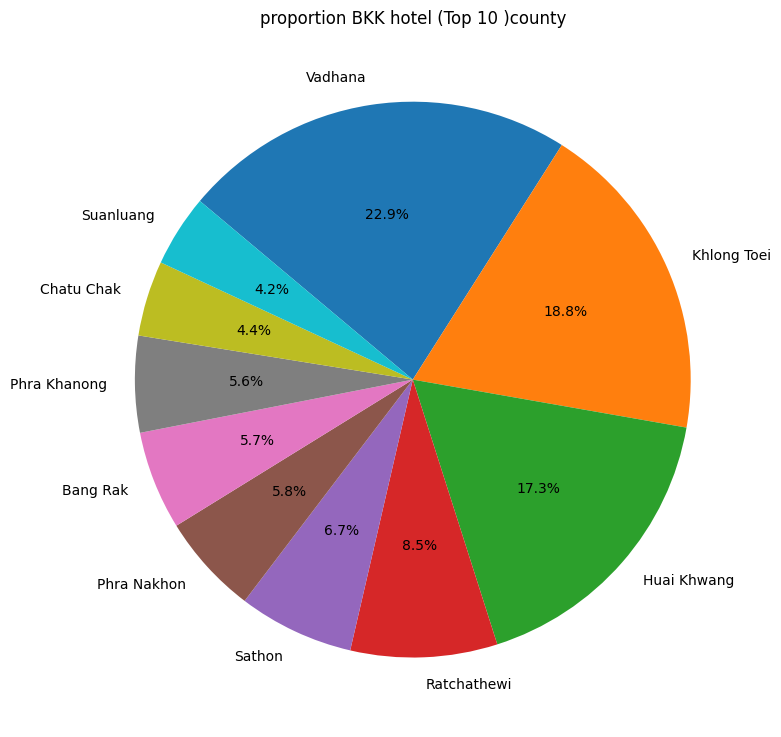

In [8]:
#แผนภูมิวงกลม: สัดส่วนห้องพักแยกตามเขต
district_pie = data["neighbourhood"].value_counts().head(10)  # เอา Top 10 เขต

plt.figure(figsize=(8, 8))
district_pie.plot(kind="pie", autopct="%1.1f%%", startangle=140, counterclock=False)
plt.ylabel("")
plt.title("proportion BKK hotel (Top 10 )county")
plt.tight_layout()

In [9]:
import plotly.graph_objects as go
import math

# ฟังก์ชันคำนวณระยะทาง (เมตร)
def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlmb/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

# -----------------------------
# พิกัดตัวอย่าง
# -----------------------------
hotel = {"name": "Hotel A", "lat": 13.7463, "lng": 100.5378}
mall  = {"name": "Siam Paragon", "lat": 13.7465, "lng": 100.5390}

# -----------------------------
# คำนวณระยะทาง
# -----------------------------
dist_m = haversine_m(hotel["lat"], hotel["lng"], mall["lat"], mall["lng"])
dist_km = dist_m / 1000

# -----------------------------
# คำนวณเวลาโดยประมาณ
# -----------------------------
# ความเร็วเฉลี่ย (หน่วย m/s)
walking_speed = 5 / 3.6   # 5 km/h
driving_speed = 30 / 3.6  # 30 km/h

time_walk_min = dist_m / walking_speed / 60
time_drive_min = dist_m / driving_speed / 60

# -----------------------------
# สร้างแผนที่ Plotly
# -----------------------------
fig = go.Figure()

# จุดโรงแรม
fig.add_trace(go.Scattermapbox(
    lat=[hotel["lat"]],
    lon=[hotel["lng"]],
    mode="markers+text",
    text=[f'{hotel["name"]}'],
    textposition="top center",
    marker=dict(size=12, color="blue"),
    name="Hotel"
))

# จุดห้าง
fig.add_trace(go.Scattermapbox(
    lat=[mall["lat"]],
    lon=[mall["lng"]],
    mode="markers+text",
    text=[f'{mall["name"]}'],
    textposition="top center",
    marker=dict(size=12, color="red"),
    name="Mall"
))

# เส้นเชื่อมโรงแรม–ห้าง
fig.add_trace(go.Scattermapbox(
    lat=[hotel["lat"], mall["lat"]],
    lon=[hotel["lng"], mall["lng"]],
    mode="lines+text",
    line=dict(width=3, color="green"),
    text=[None, f"{dist_km:.2f} km\n {time_walk_min:.1f} min\n {time_drive_min:.1f} min"],
    textposition="middle right",
    name="Distance"
))

# ตั้งค่าแผนที่
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=13,
    mapbox_center={"lat": (hotel["lat"]+mall["lat"])/2,
                   "lon": (hotel["lng"]+mall["lng"])/2},
    height=600,
    title=f"ระยะทางระหว่างโรงแรมกับห้างห่างกัน ({dist_km:.2f} กม.)",
)

fig.show()

# แสดงผลใน terminal ด้วย
print(f"ระยะทางประมาณ {dist_km:.2f} กิโลเมตร")
print(f"เวลาเดินโดยประมาณคิดเป็น {time_walk_min:.1f} นาที")
print(f"เวลาขับรถโดยประมาณ {time_drive_min:.1f} นาที")

ระยะทางประมาณ 0.13 กิโลเมตร
เวลาเดินโดยประมาณคิดเป็น 1.6 นาที
เวลาขับรถโดยประมาณ 0.3 นาที
